In [12]:
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
import pandas as pd
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap


### Data Generation -- Gaussian Mixture
def gen_data(
    k=2,
    dim=2,
    points_per_cluster=1000,
    means=None,
    covariances=None
):
    # Generate data from specified or random Gaussians
    if means is not None and covariances is None:
        raise ValueError("Covariances must be provided if means are provided.")
    if means is None:
        means = [np.random.rand(dim) for _ in range(k)]
    if covariances is None:
        covariances = [np.eye(dim) for _ in range(k)]
    x = []
    y = []
    for i in range(k):
        _x = np.random.multivariate_normal(means[i], covariances[i], points_per_cluster)
        x += list(_x)
        y += [i] * points_per_cluster
    x = np.array(x)
    y = np.array(y)
    return x, y

def create_positive_unlabeled(
    x,
    y,
    num_labeled,
    means=None,
    covariances=None,
    setting='single_data'
):
    '''
    Creates positive examples (P) and unlabeled examples (0) based on given x and y.
    input:
        - x: Input data (total_examples, features)
        - y: True labels (total_examples,)
        - num_labeled: Number of positive examples (P)
    output:
        - labels: Generated labels (total_examples,)
    '''
    if setting == 'single_data':
        feat = x
        labels = np.zeros(len(y))               # Initialize labels with all 0 (unlabeled)
        positive_indices = np.where(y == 1)[0]  # Indices of positive examples in the true labels
        selected_indices = np.random.choice(positive_indices, size=num_labeled, replace=False)
        labels[selected_indices] = 1            # Assign label 1 to selected positive examples

    elif setting == 'case_control':
        x_, y_ = gen_data(
            k=2,
            dim=2,
            points_per_cluster=num_labeled,
            means=means,
            covariances=covariances
        )
        ix = np.where(y_ == 1)[0]
        x_P = x_[ix]
        feat = np.concatenate((x, x_P), axis=0)
        labels_P = np.ones(num_labeled)
        labels_U = np.zeros(len(y))
        labels = np.concatenate((labels_U, labels_P), axis=0)


    return feat, labels


# Classification Code
def train_linear_model(
    x,
    y,
    loss_fn='ce',
    prior=0.5,
    verbose=True,
    lr=0.1,
    num_epochs=100
):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)

    model = nn.Linear(2, 2)
    if loss_fn == 'ce':
        criterion = nn.CrossEntropyLoss()
    elif loss_fn in ['uPU', 'nnPU']:
        criterion = PULoss(prior= prior, loss_fn=loss_fn)
    else:
      raise NotImplementedError

    optimizer = optim.SGD(model.parameters(), lr=lr)
    num_epochs = num_epochs
    loss_values = []
    acc = []
    for epoch in range(num_epochs):
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_values.append(loss.item())
        if (epoch + 1) % 10 == 0:

            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                logits = model(X_test_tensor)
                predicted_labels = torch.argmax(logits, dim=1)
            accuracy = accuracy_score(y_test, predicted_labels.numpy())
            acc.append(accuracy)
            if verbose:
              print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
              print(f"Accuracy: {accuracy:.4f}")

    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    with torch.no_grad():
        logits = model(X_test_tensor)
        predicted_labels = torch.argmax(logits, dim=1)
    accuracy = accuracy_score(y_test, predicted_labels.numpy())
    print(f"Accuracy: {accuracy:.4f}")

    return model, loss_values, acc



class PULoss(nn.Module):
    def __init__(self, prior, loss_fn: str):
        super(PULoss, self).__init__()
        if not 0 < prior < 1:
            raise ValueError("The class prior should be in [0, 1]")
        self.prior, self.loss_fn = prior, loss_fn
        self.meta_loss = nn.CrossEntropyLoss()

    def forward(self, logits, targets):
        # logits: shape [Batch Size \times Num of Classes] - un-normalized raw linear combination (w_i * x_i + b)
        ix_positive = torch.where(targets == 1)[0]
        ix_unlabeled = torch.where(targets == 0)[0]

        pos_logits = torch.index_select(input=logits, dim=0, index=ix_positive)
        unlabeled_logits = torch.index_select(input=logits, dim=0, index=ix_unlabeled)

        targets_pos = torch.ones(len(ix_positive), dtype=targets.dtype)
        targets_pos_inverse = torch.zeros(len(ix_positive), dtype=targets.dtype)
        targets_unlabeled = torch.zeros(len(ix_unlabeled), dtype=targets.dtype)

        # compute empirical estimates
        # R_p+
        loss_positive = self.meta_loss(pos_logits.to(logits.device), targets_pos.to(targets.device)) \
            if ix_positive.nelement() != 0 else 0
        # R_u-
        loss_unlabeled = self.meta_loss(unlabeled_logits.to(logits.device), targets_unlabeled.to(targets.device)) \
            if ix_unlabeled.nelement() != 0 else 0
        # R_p-
        loss_pos_inv = self.meta_loss(pos_logits.to(logits.device), targets_pos_inverse.to(targets.device)) \
            if ix_positive.nelement() != 0 else 0
        # (1-pi) Rn- = R_u- - prior * R_p-
        loss_negative = loss_unlabeled - self.prior * loss_pos_inv

        if self.prior == 0:
            prior = ix_positive.nelement() / (ix_positive.nelement() + ix_unlabeled.nelement())
            # i.e. fully supervised equivalent to PN strategy
            return prior * loss_unlabeled + (1 - prior) * loss_positive
        elif self.loss_fn == 'nnPU':
            return - loss_negative if loss_negative < 0 else self.prior * loss_positive + loss_negative
        elif self.loss_fn == 'uPU':
            return self.prior * loss_positive + loss_negative
        else:
            ValueError('Unsupported Loss')


def puPL(x_PU, y_PU, num_clusters=2):
    p_ix = y_PU==1
    u_ix = y_PU==0
    x_P = x_PU[p_ix]
    x_U = x_PU[u_ix]

    ## Initialize Cluster Centers ##
    # Compute the mean of x_P as the first centroid: Note centroid_2 since we use P:1 N/U:0
    centroid_2 = np.mean(x_P, axis=0)
    # Use K-means++ to choose the second center from x_U given the first center
    kmeans_pp = KMeans(n_clusters=1, init=np.array([centroid_2]))
    kmeans_pp.fit(x_U)
    centroid_1 = kmeans_pp.cluster_centers_[0]
    centroids = np.array([centroid_1, centroid_2]) # Initialize the centroids with the computed values

    ## Perform K-means clustering with the initialized centroids
    kmeans = KMeans(n_clusters=num_clusters, init=centroids)
    kmeans.fit(np.concatenate((x_U, x_P), axis=0))

    labels = kmeans.labels_
    data = np.concatenate((x_U, x_P), axis=0)

    return labels, data

### Viz Data ---- Scatter Plot
def plot_scatter(x, y, label_colors, model=None, lbl_map=None):
    # Plots a scatter plot of the generated data
    data = {'X': x[:, 0], 'Y': x[:, 1], 'Label': y}
    df = pd.DataFrame(data)
    if lbl_map is not None:
        df['Label'] = df['Label'].map(lbl_map)  # Map labels 0 to 'N' and 1 to 'P'
    sns.scatterplot(
        data=df,
        x='X',
        y='Y',
        hue='Label',
        palette=label_colors,
        s=60,
        alpha=0.8,
        edgecolor='k',
        marker='o',
    )

def plot_decision_boundary(X, y, model,
                           boundary_color='k',
                           boundary_linestyle='-'):
    # Generate a grid of points to plot the decision boundary
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000),
                         np.linspace(y_min, y_max, 1000))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_points_tensor = torch.tensor(grid_points, dtype=torch.float32)
    with torch.no_grad():
        logits = model(grid_points_tensor)
        predicted_labels = torch.argmax(logits, dim=1)
    # Reshape the predicted labels to match the grid shape
    decision_map = predicted_labels.reshape(xx.shape)
    CS = plt.contour(xx, yy,
                         decision_map,
                         alpha=0.5,
                         colors=boundary_color,
                         linestyles=boundary_linestyle
                    )
    # plt.clabel(CS, inline=1, fontsize=10)

In [13]:
# supervised
# Generate Data (PN) from Gaussians
mean1 = np.array([0, 0])  # Mean of first cluster
cov1 = np.array([[0, 0.5], [0.5, 0]])  # Covariance matrix of first cluster

# mean2 = np.array([3.5, 3.5])  # Mean of second cluster
# cov2 = np.array([[1, 0.5], [0.5, 2]])  # Covariance matrix of second cluster
mean2 = np.array([3.5, 3.5])  # Mean of second cluster
cov2 = np.array([[0, 0.5], [1, 0]])  # Covariance matrix of second cluster

means = [mean1, mean2]
covariances = [cov1, cov2]
point_per_cluster = 1500

x, y = gen_data(
    k=2,
    dim=2,
    points_per_cluster=point_per_cluster,
    means=means,
    covariances=covariances
)
model_opt, loss_opt, acc_opt = train_linear_model(x, y, loss_fn='ce', lr=0.1, num_epochs=1000, verbose=False)
plt.figure(figsize=(8,6), dpi=300)
label_colors = [
    '#d62728',
    '#1f77b4'
]
lbl_map = {
    0: r'$y^\ast = 0$',
    1: r'$y^\ast = 1$'
}
plot_scatter(x, y, label_colors, lbl_map=lbl_map)
plot_decision_boundary(x, y, model_opt, boundary_color='k')
plt.annotate(
    r'CE$^\ast$',
    xy=(4.7, -0.9),
    fontsize=12,
    fontweight='bold',
    color='k'
)
plt.xlabel('X0', fontweight='bold')
plt.ylabel('X1', fontweight='bold')
plt.legend(loc='upper left', ncol=3, fontsize=20, prop={'weight': 'bold', 'size':'large'}, bbox_to_anchor=(0, 1.1))
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

/var/folders/8c/br5wk04x7616nc7rcdx8fxj80000gq/T/ipykernel_14150/893648057.py:35: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  _x = np.random.multivariate_normal(means[i], covariances[i], points_per_cluster)


Accuracy: 1.0000


In [14]:
nP_L = 500
# prior_true = (point_per_cluster - nP_L) / (point_per_cluster*2 - nP_L)
prior_true=0.5
x_PU, y_PU = create_positive_unlabeled(
    x,
    y,
    num_labeled=nP_L,
    means=means,
    covariances=covariances,
    setting='case_control'
    )
model_opt, loss_opt, acc_opt = train_linear_model(x, y, loss_fn='ce', lr=0.1, num_epochs=1000, verbose=False)
# CE
model_CE, loss_CE, acc_CE = train_linear_model(x_PU, y_PU, loss_fn='ce', lr=0.1, num_epochs=1000, verbose=False)
# # uPU
# model_uPU, loss_uPU, acc_uPU = train_linear_model(x_PU, y_PU, loss_fn='uPU', lr=0.0001, prior=prior_true, num_epochs=100, verbose=False)
# nnPU
model_nnPU, loss_nnPU, acc_nnPU = train_linear_model(x_PU, y_PU, loss_fn='nnPU', lr=0.005, prior=prior_true, num_epochs=100, verbose=False)
# puPL + CE
y_hat_PU, x_hat_PU = puPL(x_PU, y_PU, num_clusters=2)                                                           # get pseudo-labels
model_puPL, loss_puPL, acc_puPL = train_linear_model(x_PU, y_hat_PU, loss_fn='ce', lr=0.1, num_epochs=1000, verbose=False)  # train with puPL + CE

/var/folders/8c/br5wk04x7616nc7rcdx8fxj80000gq/T/ipykernel_14150/893648057.py:35: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  _x = np.random.multivariate_normal(means[i], covariances[i], points_per_cluster)


Accuracy: 1.0000
Accuracy: 0.8614
Accuracy: 0.4529


/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)


Accuracy: 0.9986


In [15]:
### Viz Data ---- Scatter Plot

def plot_scatter(x, y, label_colors, model=None, lbl_map=None):
    # Plots a scatter plot of the generated data
    data = {'X': x[:, 0], 'Y': x[:, 1], 'Label': y}
    df = pd.DataFrame(data)
    if lbl_map is not None:
        df['Label'] = df['Label'].map(lbl_map)  # Map labels 0 to 'N' and 1 to 'P'
    sns.scatterplot(
        data=df,
        x='X',
        y='Y',
        hue='Label',
        palette=label_colors,
        s=60,
        alpha=0.8,
        edgecolor='k',
        marker='o',
    )

def plot_decision_boundary(X, y, model,
                           boundary_color='k',
                           boundary_linestyle='-'):
    # Generate a grid of points to plot the decision boundary
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000),
                         np.linspace(y_min, y_max, 1000))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_points_tensor = torch.tensor(grid_points, dtype=torch.float32)
    with torch.no_grad():
        logits = model(grid_points_tensor)
        predicted_labels = torch.argmax(logits, dim=1)
    # Reshape the predicted labels to match the grid shape
    decision_map = predicted_labels.reshape(xx.shape)
    CS = plt.contour(xx, yy,
                         decision_map,
                         alpha=0.5,
                         colors=boundary_color,
                         linestyles=boundary_linestyle
                    )
    # plt.clabel(CS, inline=1, fontsize=10)

# Experiments 

In [16]:
# supervised
# Generate Data (PN) from Gaussians
mean1 = np.array([0, 0])  # Mean of first cluster
cov1 = np.array([[0, 0.5], [0.5, 0]])  # Covariance matrix of first cluster

# mean2 = np.array([3.5, 3.5])  # Mean of second cluster
# cov2 = np.array([[1, 0.5], [0.5, 2]])  # Covariance matrix of second cluster
mean2 = np.array([3.5, 3.5])  # Mean of second cluster
cov2 = np.array([[0, 0.5], [1, 0]])  # Covariance matrix of second cluster

means = [mean1, mean2]
covariances = [cov1, cov2]
point_per_cluster = 1500

x, y = gen_data(
    k=2,
    dim=2,
    points_per_cluster=point_per_cluster,
    means=means,
    covariances=covariances
)
model_opt, loss_opt, acc_opt = train_linear_model(x, y, loss_fn='ce', lr=0.1, num_epochs=1000, verbose=False)
# plt.figure(figsize=(8,6), dpi=300)
# label_colors = [
#     '#d62728',
#     '#1f77b4'
# ]
# lbl_map = {
#     0: r'$y^\ast = 0$',
#     1: r'$y^\ast = 1$'
# }
# plot_scatter(x, y, label_colors, lbl_map=lbl_map)
# plot_decision_boundary(x, y, model_opt, boundary_color='k')
# plt.annotate(
#     r'CE$^\ast$',
#     xy=(4.7, -0.9),
#     fontsize=12,
#     fontweight='bold',
#     color='k'
# )
# plt.xlabel('X0', fontweight='bold')
# plt.ylabel('X1', fontweight='bold')
# plt.legend(loc='upper left', ncol=3, fontsize=20, prop={'weight': 'bold', 'size':'large'}, bbox_to_anchor=(0, 1.1))
# plt.grid(True, linestyle='--', alpha=0.6)
# plt.show()

/var/folders/8c/br5wk04x7616nc7rcdx8fxj80000gq/T/ipykernel_14150/893648057.py:35: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  _x = np.random.multivariate_normal(means[i], covariances[i], points_per_cluster)


Accuracy: 1.0000


In [17]:
nP_L = 500
# prior_true = (point_per_cluster - nP_L) / (point_per_cluster*2 - nP_L)
prior_true=0.5
x_PU, y_PU = create_positive_unlabeled(
    x,
    y,
    num_labeled=nP_L,
    means=means,
    covariances=covariances,
    setting='case_control'
    )
model_opt, loss_opt, acc_opt = train_linear_model(x, y, loss_fn='ce', lr=0.1, num_epochs=1000, verbose=False)
# CE
model_CE, loss_CE, acc_CE = train_linear_model(x_PU, y_PU, loss_fn='ce', lr=0.1, num_epochs=1000, verbose=False)
# # uPU
# model_uPU, loss_uPU, acc_uPU = train_linear_model(x_PU, y_PU, loss_fn='uPU', lr=0.0001, prior=prior_true, num_epochs=100, verbose=False)
# nnPU
model_nnPU, loss_nnPU, acc_nnPU = train_linear_model(x_PU, y_PU, loss_fn='nnPU', lr=0.005, prior=prior_true, num_epochs=100, verbose=False)
# puPL + CE
y_hat_PU, x_hat_PU = puPL(x_PU, y_PU, num_clusters=2)                                                           # get pseudo-labels
model_puPL, loss_puPL, acc_puPL = train_linear_model(x_PU, y_hat_PU, loss_fn='ce', lr=0.1, num_epochs=1000, verbose=False)  # train with puPL + CE

/var/folders/8c/br5wk04x7616nc7rcdx8fxj80000gq/T/ipykernel_14150/893648057.py:35: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  _x = np.random.multivariate_normal(means[i], covariances[i], points_per_cluster)


Accuracy: 1.0000
Accuracy: 0.8600
Accuracy: 0.1486


/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)


Accuracy: 1.0000


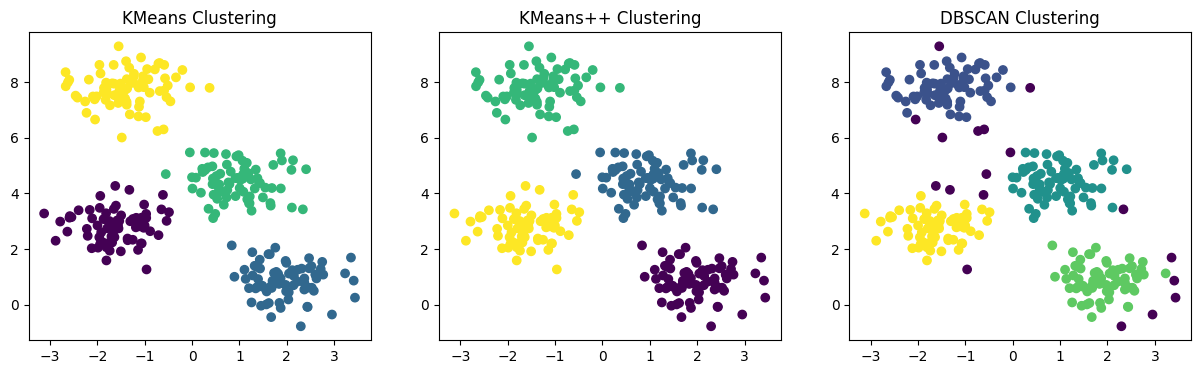

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, DBSCAN

# Generate synthetic data
X, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)

# Apply KMeans
kmeans = KMeans(n_clusters=4, init='random', n_init=10, max_iter=300, random_state=0)
kmeans_labels = kmeans.fit_predict(X)

# Apply KMeans with smart initialization (KMeans++)
kmeans_plus = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=300, random_state=0)
kmeans_plus_labels = kmeans_plus.fit_predict(X)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X)

# Plotting
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

ax[0].scatter(X[:, 0], X[:, 1], c=kmeans_labels, cmap='viridis', marker='o')
ax[0].set_title('KMeans Clustering')

ax[1].scatter(X[:, 0], X[:, 1], c=kmeans_plus_labels, cmap='viridis', marker='o')
ax[1].set_title('KMeans++ Clustering')

ax[2].scatter(X[:, 0], X[:, 1], c=dbscan_labels, cmap='viridis', marker='o')
ax[2].set_title('DBSCAN Clustering')

plt.show()
